In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.optim as optim

from data_helpers import plot_photons_histograms
from model import ConditionalModel
from diffusion import make_beta_schedule, GaussianDiffusion 

DATA_PATH = "/data2/etude/annkon/data"
CKPT_PATH = "/data2/etude/annkon/checkpoints"

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


(9957622, 6)


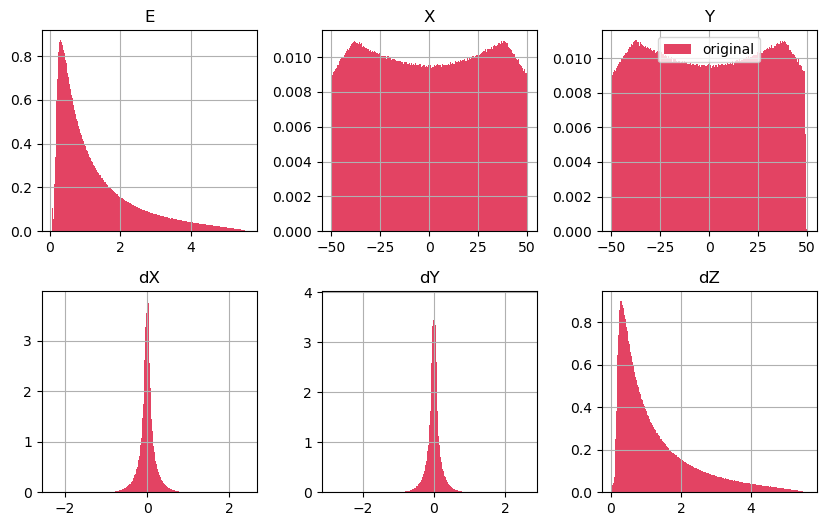

In [2]:
photons = np.load(f'{DATA_PATH}/photons_XYTE_E5.6_s0.0_a1.5.npy')
print(photons.shape)
figs, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
plot_photons_histograms(photons, axs, figs, title='')

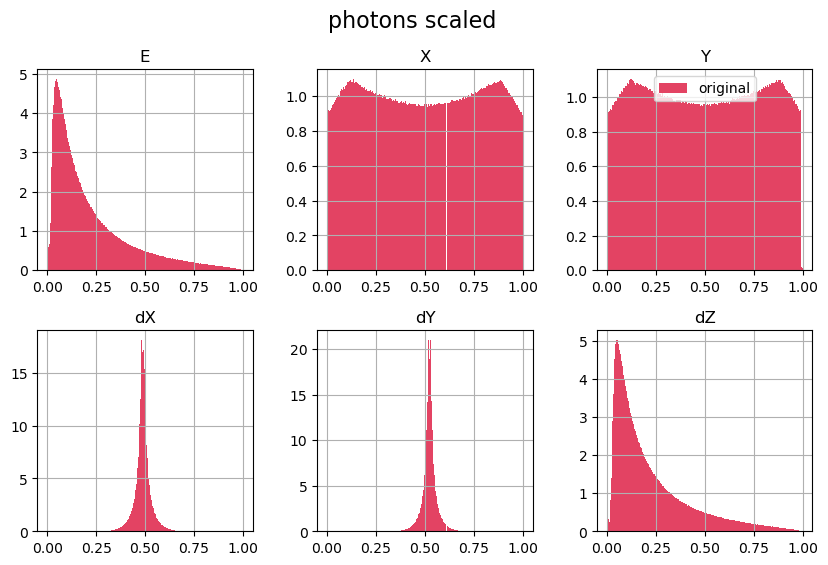

In [3]:
mmsc = MinMaxScaler()
photons_mm = mmsc.fit_transform(photons)
figs, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
plot_photons_histograms(photons_mm, axs, figs, title='photons scaled')

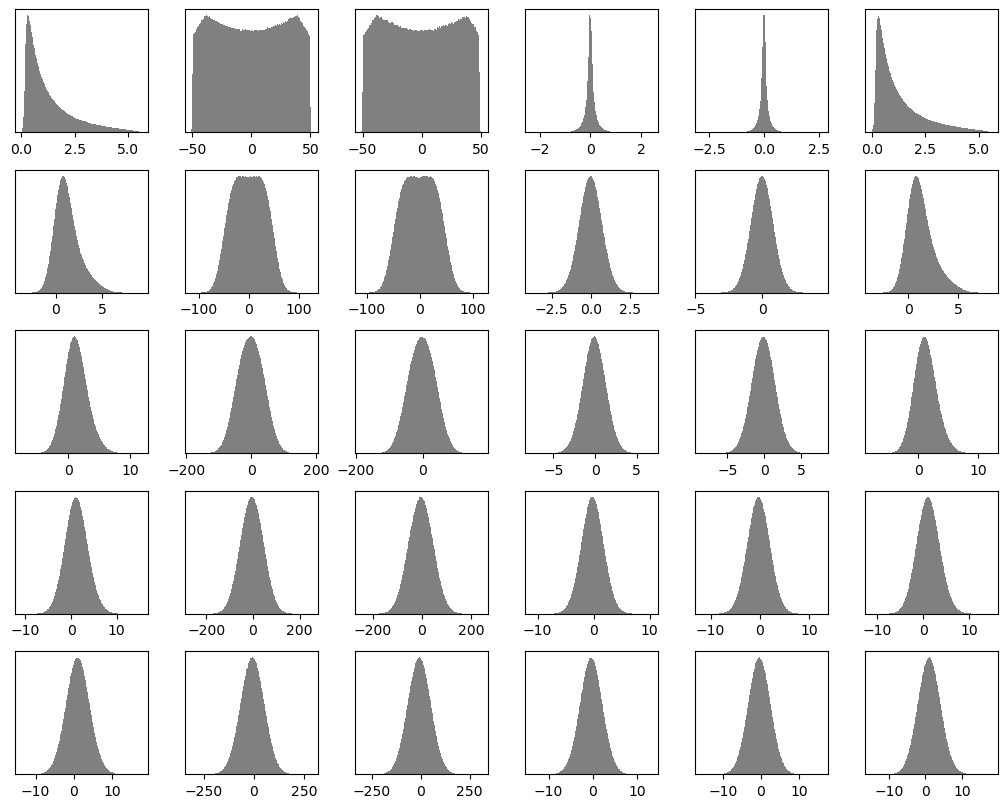

In [4]:
n_steps = 100
betas = make_beta_schedule(schedule='linear', n_timesteps=n_steps, start=1e-5, end=1e-2)
diffusion = GaussianDiffusion(betas=betas)


def plot_diffusion():
    figs, axs = plt.subplots(nrows=5, ncols=6, figsize=(10,8))
    for i in range(5):
        q_i = diffusion.q_sample(dataset, torch.tensor([i * 20]).to(device))
        inv_q_i = mmsc.inverse_transform(q_i.detach().cpu().numpy())
        for j in range(6):
            axs[i][j].hist(inv_q_i[:, j], bins=300, color='grey', density=True)
            axs[i][j].set_yticks([])
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        
dataset = torch.tensor(photons_mm).float().to(device)
plot_diffusion()

In [5]:
model = ConditionalModel(n_steps)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(photons_mm).float().to(device)
n_epochs = 301


batch_size = 10000
for t in range(n_epochs):
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices].to(device)
        loss = diffusion.noise_estimation_loss(model, batch_x)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    if (t % 100 == 0):
        print(loss)
        torch.save({
            'epoch' : t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }, f"{CKPT_PATH}/DDPM_XYTE_warmup50_noema_epoch{t}.pt")

tensor(0.2632, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2218, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2222, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2180, device='cuda:1', grad_fn=<MeanBackward0>)
